## Under-sampling Method Comparison

We will determine if the different under-sampling algorithms discussed in this section improve the performance of Random Forests on different datasets with imbalanced classes.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [2]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        max_iter=100),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),

    'iht': InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3)
}

In [3]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [4]:
# print class imbalance

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [5]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [6]:
# to save the results
results_dict = {}
shapes_dict = {}

for dataset in datasets_ls:
    
    results_dict[dataset] = {}
    shapes_dict[dataset] = {}
    
    print(dataset)
    
    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(
    data.data,  
    data.target, 
    test_size=0.3,
    random_state=0)
    
    # as many undersampling techniques use KNN
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    
    # store results
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)
    
    print()
    
    for undersampler in undersampler_dict.keys():
        
        print(undersampler)
        
        # resample
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
        
        # evaluate performance
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        #store results
        results_dict[dataset][undersampler] = roc
        shapes_dict[dataset][undersampler] = len(X_resampled)
        print()
        
    print()
        

car_eval_34
Train set
Random Forests roc-auc: 0.9730903165319881
Test set
Random Forests roc-auc: 0.826061776061776

random
Train set
Random Forests roc-auc: 0.9892751479289941
Test set
Random Forests roc-auc: 0.8254826254826255

cnn
Train set
Random Forests roc-auc: 0.9530956848030019
Test set
Random Forests roc-auc: 0.8268339768339769

tomek
Train set
Random Forests roc-auc: 0.9601231128684399
Test set
Random Forests roc-auc: 0.8096525096525096

oss
Train set
Random Forests roc-auc: 0.957703304558201
Test set
Random Forests roc-auc: 0.7922779922779922

enn
Train set
Random Forests roc-auc: 0.9664294554455445
Test set
Random Forests roc-auc: 0.834041184041184

renn
Train set
Random Forests roc-auc: 0.9762014675154284
Test set
Random Forests roc-auc: 0.8323037323037322

allknn
Train set
Random Forests roc-auc: 0.9764543269230769
Test set
Random Forests roc-auc: 0.8305662805662806

ncr
Train set
Random Forests roc-auc: 0.963874593716143
Test set
Random Forests roc-auc: 0.82001287001287


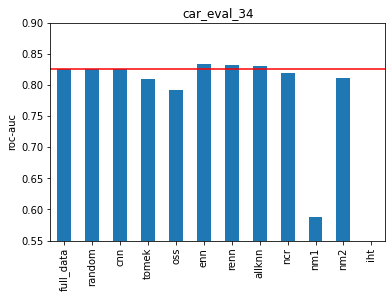

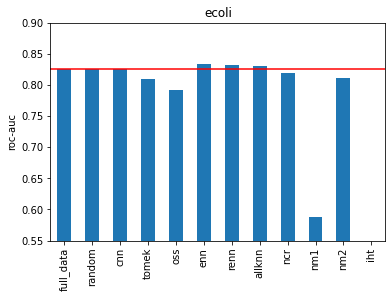

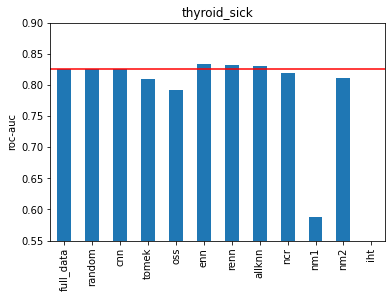

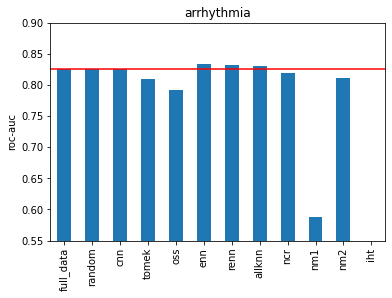

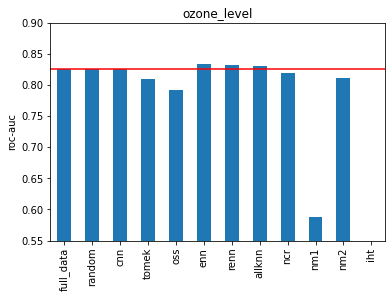

In [7]:
for dataset in datasets_ls:
    
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.ylim(0.55, 0.9)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

The different versions of **Edited Nearest Neighbours** tend to provide a tiny bit of performance improvement.

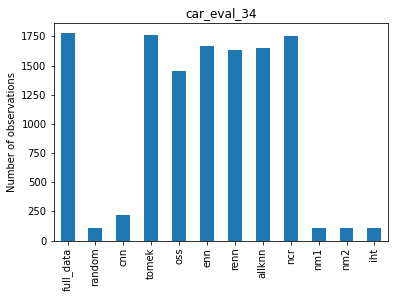

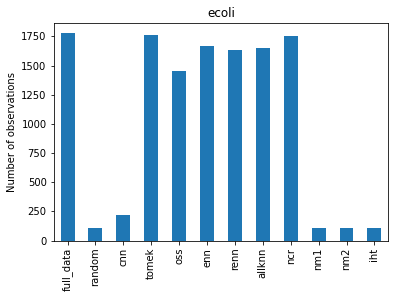

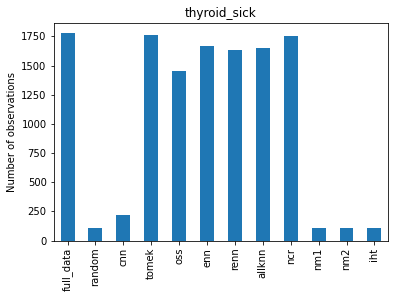

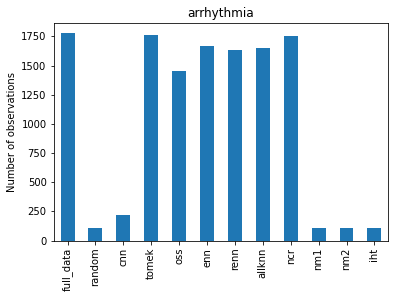

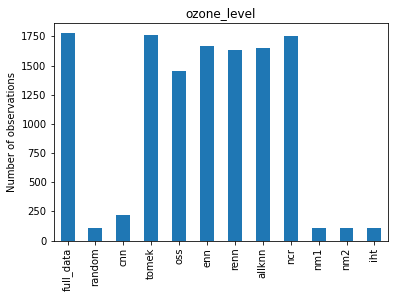

In [8]:
for dataset in datasets_ls:
    
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()